In [18]:
import torch
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.utils.data import DataLoader

from skpm import event_logs

from ppm.datasets import ContinuousTraces, DatasetSchemas
from ppm.datasets.event_logs import EventFeatures, EventLog, EventTargets
from ppm.datasets.utils import continuous
from ppm.models import OutcomePredictor
from ppm.engine.utils import load_checkpoint
from ppm.utils import parse_args, add_outcome_labels, prepare_data, get_model_config

# Prepare data & model

In [19]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

NUMERICAL_FEATURES = [
    "accumulated_time",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "hour_of_day",
    "min_of_hour",
    "month_of_year",
    "sec_of_min",
    "secs_within_day",
    "week_of_year",
]

In [20]:
config_path = r'D:\PycharmProjects\xAI-PPM\configs\explain_lstm_args_for_op.txt'
checkpoints_path = r'D:\PycharmProjects\xAI-PPM\persisted_models\suffix\BPI17_lstm_single_task_op.pth'

args = parse_args(config_path=config_path)
args.dataset = 'BPI17'

config = {
    # args to pop before logging
    "project_name": args.project_name,
    "checkpoint_path": checkpoints_path,
    # args to log
    "log": args.dataset,
    "device": args.device,
    # architecture
    "backbone": args.backbone,
    "rnn_type": args.rnn_type,
    "embedding_size": args.embedding_size,
    "hidden_size": args.hidden_size,
    "n_layers": args.n_layers,
    # hyperparameters
    "batch_size": 1,       
    # features and tasks
    "categorical_features": args.categorical_features,
    "continuous_features": (
        NUMERICAL_FEATURES
        if (
            args.continuous_features is not None
            and "all" in args.continuous_features
        )
        else args.continuous_features
    ),
    "categorical_targets": args.categorical_targets,
    "continuous_targets": args.continuous_targets,
    "strategy": args.strategy,
}

In [21]:
log = getattr(event_logs, config["log"])()

labels_dict = {"O_Cancelled": 0, "O_Accepted": 1, "O_Refused": 2}
column_schema = getattr(DatasetSchemas, config["log"])()
labeled_df = add_outcome_labels(log.dataframe, column_schema, labels_dict)

# Remove O_Refused to convert the task to a binary classification
binary_labeled_df = labeled_df[labeled_df["outcome"] != 2]
print(
        "Outcomes of the cases are ",
        binary_labeled_df["last_o_activity"].unique().tolist(),
)
result = prepare_data(
        binary_labeled_df,
        log.unbiased_split_params,
        NUMERICAL_FEATURES,
        include_labels=True,
    )
# prepare_data may return either (train, test) or (train, test, train_timestamps, test_timestamps)
if isinstance(result, tuple) and len(result) == 4:
    train, test, _, test_timestamps = result
elif isinstance(result, tuple) and len(result) == 2:
    train, test = result
else:
    raise ValueError("Unexpected return value from prepare_data()")

event_features = EventFeatures(
    categorical=config["categorical_features"],
    numerical=config["continuous_features"],
)
event_targets = EventTargets(
    categorical=config["categorical_targets"],
    numerical=config["continuous_targets"],
)

train_log = EventLog(
    dataframe=train,
    case_id="case_id",
    features=event_features,
    targets=event_targets,
    train_split=True,
    name=config["log"],
)

test_log = EventLog(
    dataframe=test,
    case_id="case_id",
    features=event_features,
    targets=event_targets,
    train_split=False,
    name=config["log"],
    vocabs=train_log.get_vocabs(),
)

dataset_device = (
    config["device"]
    if config["backbone"]
    not in ["gpt2", "llama32-1b", "llama2-7b", "qwen25-05b"]
    else "cpu"
)

train_dataset = ContinuousTraces(
    log=train_log,
    refresh_cache=True,
    device=dataset_device,
)
test_dataset = ContinuousTraces(
    log=test_log,
    refresh_cache=True,
    device=dataset_device,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=continuous,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=continuous,
)

Outcomes of the cases are  ['O_Accepted', 'O_Cancelled']


In [22]:
# Loading a pre-trained model
model_config = get_model_config(test_log, config)
model_config.pop("categorical_targets", None)
model_config.pop("numerical_targets", None)
model = OutcomePredictor(**model_config).to(device=config["device"])

ckpt = load_checkpoint(config["checkpoint_path"], map_location=config["device"])
if isinstance(ckpt, dict) and 'net' in ckpt.keys():
    ckpt = ckpt['net']
model.load_state_dict(ckpt)

 [*] Loading checkpoint from D:\PycharmProjects\xAI-PPM\persisted_models\suffix\BPI17_lstm_single_task_op.pth succeed!


<All keys matched successfully>

In [23]:
model.eval()

total_targets=0
device = config["device"]

valid_positions = {}
metrics = {"acc": 0.0}
with torch.inference_mode():
    for batch, items in enumerate(test_loader):
        x_cat, x_num, y_cat, y_num = items
        x_cat, x_num, y_cat, y_num = (
                x_cat.to(device),
                x_num.to(device),
                y_cat.to(device),
                y_num.to(device),
            )

        attention_mask = (x_cat[..., 0] != 0).long()
        total_targets += y_cat.shape[0]  # attention_mask.sum().item()

        # with torch.autocast(device_type=device, dtype=torch.float16):
        out, _ = model(x_cat=x_cat, x_num=x_num, attention_mask=attention_mask)

        predictions = ((out.squeeze(1)) > 0.5).float()
        acc = (predictions.squeeze() == y_cat.squeeze()).sum().item()
        metrics["acc"] += acc
            
        max_len = attention_mask.size(1)
        idxs = torch.arange(max_len).unsqueeze(0).to(device)  # [1, S]
        lengths = attention_mask.sum(dim=-1)  # [B]
        mask = idxs < lengths.unsqueeze(1)  # [B, S]
            
        correct = (predictions.squeeze() == y_cat.squeeze()) & mask
        for t in range(max_len):
            valid = mask[:, t]
            if valid.any():
                acc_t = correct[:, t][valid].float().sum()
            else:
                acc_t = torch.tensor(float("nan"))
            metrics.setdefault(f"acc_pos_{t}", 0.0)
            metrics[f"acc_pos_{t}"] += acc_t.item()
            valid_positions.setdefault(f"acc_pos_{t}", 0)
            valid_positions[f"acc_pos_{t}"] += valid.sum().item()
            # metrics["test_outcome"]["acc"] += acc

    for k in metrics.keys():
        if k.startswith("acc_pos_"):
            metrics[k] /= valid_positions[k]
        else:
            metrics[k] /= total_targets


# Extract cases for generating explanations

In [24]:
# a) Extracting sequences that predicted to have "O_Cancelled" as an outcome of the given trace

o_cancelled_ids = []
o_cancelled_cases = []

pred_prefix_pos =  25

for ind, batch in enumerate(test_loader):
    x_cat, x_num, _, _ = batch # type: ignore
    x_cat, x_num = x_cat[:, :-1, :], x_num[:, :-1, :]
    x_cat, x_num = (x_cat.to(dataset_device), x_num.to(dataset_device))

    attention_mask = (x_cat[..., 0] != 0).long()
    out, _ = model(x_cat=x_cat, x_num=x_num, attention_mask=attention_mask)
    prediction = ((out.squeeze(1)) > 0.5).float()
    try:
        if pred_prefix_pos < prediction.size(1):
            trunc_prediction = prediction[:, pred_prefix_pos]
        else:
            trunc_prediction = prediction[:, -1] 
            pred_prefix_pos = prediction.size(1) - 1   
    except Exception as e:
        print("Failed to get prediction at position ", pred_prefix_pos, "with the following error", e)

    # Extracting cases with "O_Cancelled" outcome  
    if trunc_prediction.item() == 0:
        o_cancelled_ids.append(ind)
        case_to_explain = np.concatenate([x_cat[:,:pred_prefix_pos, :].numpy(), 
                                          x_num[:,:pred_prefix_pos, :].numpy()], axis=-1)
        o_cancelled_cases.append(case_to_explain)
    pred_prefix_pos = 25

print(f'The following {len(o_cancelled_cases)} cases that derived "O_Cancelled" prediction for the outcome will be explained')

The following 3505 cases that derived "O_Cancelled" prediction for the outcome will be explained


In [25]:
o_cancelled_ids

[1,
 6,
 7,
 10,
 11,
 14,
 15,
 17,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 32,
 35,
 41,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 52,
 53,
 55,
 56,
 57,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 69,
 71,
 73,
 74,
 78,
 81,
 83,
 84,
 86,
 87,
 88,
 89,
 92,
 93,
 96,
 97,
 99,
 102,
 108,
 109,
 111,
 112,
 113,
 118,
 119,
 120,
 121,
 122,
 123,
 126,
 129,
 133,
 134,
 136,
 137,
 139,
 140,
 141,
 143,
 144,
 146,
 147,
 153,
 156,
 157,
 158,
 160,
 161,
 162,
 163,
 164,
 166,
 167,
 177,
 181,
 182,
 183,
 185,
 187,
 189,
 194,
 195,
 198,
 199,
 200,
 201,
 202,
 204,
 205,
 210,
 213,
 214,
 218,
 220,
 222,
 227,
 229,
 230,
 231,
 234,
 235,
 240,
 242,
 243,
 244,
 246,
 247,
 249,
 251,
 254,
 255,
 256,
 257,
 258,
 259,
 262,
 263,
 264,
 265,
 266,
 267,
 270,
 271,
 274,
 276,
 278,
 281,
 282,
 284,
 286,
 288,
 290,
 292,
 293,
 294,
 302,
 305,
 307,
 310,
 313,
 315,
 318,
 319,
 321,
 326,
 333,
 336,
 338,
 340,
 341,
 342,
 343,
 344,
 347,
 348,
 349,
 350

In [26]:
o_created_ind = 15
one_offer_ids = []
multiple_offers = {}

# Extracting cases ids from the o_cancelled_cases list with only one offer event in the trace
for i, case in enumerate(o_cancelled_cases): 
    offered_times = np.where(case[0, :, 0] == o_created_ind)[0].size 
    if offered_times == 1:
        one_offer_ids.append(i)
    else:
        multiple_offers[i] = offered_times
print("Number of cases with one offer:", len(one_offer_ids))
print("Number of cases with more than one offer:", len(multiple_offers))
print("(Number of offers per case, frequency):", list(Counter(multiple_offers.values()).items()))
# mo_statistics_perc = {k: np.round((v/len(multiple_offers))*100, 2) for k, v in mo_statistics.items()}

Number of cases with one offer: 2104
Number of cases with more than one offer: 1401
(Number of offers per case, frequency): [(4, 55), (3, 198), (2, 1110), (5, 11), (0, 23), (6, 4)]


In [27]:
oc_trace_id = one_offer_ids[10]
trace_id_testlog = o_cancelled_ids[oc_trace_id]
print('Id of the case to be explaianed:', trace_id_testlog)
case_to_segment = o_cancelled_cases[oc_trace_id]
print('Case length:', case_to_segment.shape[1])
trace_to_segment = case_to_segment[0, :, 0]
trace_to_segment

Id of the case to be explaianed: 41
Case length: 18


array([ 7., 11., 24., 24., 23.,  6.,  3., 15., 16., 18., 23., 21., 21.,
        5., 21., 21., 21.,  4.])

# Trace Segmentation

## Information gain-based segmentation

In [28]:
def SH_Entropy(x):
    x = x[(x != 0)]
    p = np.true_divide(x,np.sum(x))
    return -1 * sum(p * np.log(p))


def IG_Cal_Incremental(IG_old,Integ_TS,pos_old,new_pos):
    """
    Calculates the information gain incrementally, based off the information
    gain previously recorded.

    This function works by finding the segment for which the new_pos splits
    in two. It then subtracts the information gain for the whole segment and
    adds the IG for the split segments. This operation has complexity O(

    :param IG_old: The information Gain of Integ_TS with positions pos_old
    :param Integ_TS: The integral (cumulative sum) of the time series to 
                    calculate the information gain on. 
                    Representes as a numpy array of shape (number of series, time)
    :param pos_old: The positions on Integ_TS that have IG_old IG
                    Represented as a numpy aray of integer positions
    :param new_pos: The new position to add to the Integ_TS, integer

    :returns: float representing the information gain of Integ_TS over pos_old 
                and new_pos splits
    """
    Num_TS = Integ_TS.shape[0]
    Len_TS = Integ_TS.shape[1]

    # Working array to keep the new values in
    TS_dist = np.zeros(Num_TS).astype(float)

    # The positions of the segment boundaries higher and lower than the new_pos
    lower = max([-1]+ [x for x in pos_old if x <= new_pos])
    higher = min([Len_TS-1] + [x for x in pos_old if x >= new_pos])

    # Calculate the entropy of the whole old segment
    for j in range(Num_TS):
        # This operation here is meant to get the sum of all the elements between
        # lower and higher, not inclusive of higher. If lower is the very 
        # beginning of the time series (represented as lower = -1), then the 
        # cumulative sum at higher is equal to the sum between the start and higher
        if lower == -1:
            TS_dist[j] = Integ_TS[j,higher]
        else:
            TS_dist[j] = Integ_TS[j,higher] - Integ_TS[j,lower]
    old_entroy = SH_Entropy(TS_dist)

    # Use the same method to calculate the entropy of the left segment and then
    # the right
    for j in range(Num_TS):
        if lower == -1:
            TS_dist[j] = Integ_TS[j,new_pos]
        else:
            TS_dist[j] = Integ_TS[j,new_pos] - Integ_TS[j,lower]
    new_entropy_left = SH_Entropy(TS_dist)

    for j in range(Num_TS):
        TS_dist[j] = Integ_TS[j,higher] - Integ_TS[j,new_pos]

    new_entropy_right = SH_Entropy(TS_dist)

    # Then we calculate the change in weighted entropy
    weighted_right = (higher - new_pos) * new_entropy_right / Len_TS
    weighted_old = (higher - lower) * old_entroy / Len_TS
    weighted_left = (new_pos - lower) * new_entropy_left / Len_TS

    entropy_change = weighted_old - weighted_left - weighted_right

    return IG_old + entropy_change

In [29]:
def TopDown(Multivar_TS, k, step):
    """
    Top down IGTS. This method of IGTS tries to greedily find the next segment
    location that creates the maximum information gain. Once this is found, it
    repeats the process until we have k splits in the time series.

    :param Multivar_TS: a numpy array of dimensions (amount of channels, time).
    :param k: The amount of splits to find in the time series. Which makes the
              amount of segments equal to k + 1(int)
    :param step: The size of the steps to make when searching through the time
                 series to find the heighest value. For instance, a step of 5
                 will find the max IG out of 0...5...10 etc
    :param double: paramater passed to Clean_TS for the purpose of removing
                   correlation from the time series. Leaving it at 1 is reccomended

    :return: (splits,InformationGain,knee)
             splits is a numpy array of integers of size <= k
             The amount of splits (that I will call n) can be smaller than or
             equal to k. It is smaller than k when creating any more segments
             does not increase information gain. This usually (by experience)
             does not occur when the amount of splits is larger than 50% of
             the time series.

             splits represents the positions of splits that are found to be optimal in
             the time series. These splits are after the position they index,
             for instance, if there is a 2 in the array, then {0,1,2} is one
             segment and {3,4,5...} is another. The order of this array is
             important, and is not sorted. The first element is the split that
             was found to have the highest information gain, and the second has
             the second heighest, etc.

             Information Gain is an numpy array of floats of size n. The ith element of the
             arary represents the information gain found for the first i segments.

             knee is a number <= n that is the knee point of the time series.
             Choosing a balance between
             number of segments (usually creating a larger amount of information
             gain) vs the size of the segments (too many segments can make them
             very small). The knee point of the information gain vs segments
             curve is returned to knee.
    """

    # Pre Process the time series
    Integ_TS = Multivar_TS # Clean_TS(Multivar_TS, double)

    # get size of the input
    if Integ_TS.ndim == 1:
        Len_TS = Integ_TS.shape[0]
    else:
        Len_TS = Integ_TS.shape[1]

    # maxTT is the segments found for the maximum IG found so far
    maxTT = np.zeros(k + 1).astype(int)

    # tryTT is the working segments, that we will be trying
    tryTT = np.zeros(k + 1).astype(int)

    # IG_arr is the information gain found for k
    IG_arr = np.zeros(k + 1)
    IG_arr[0] = 0

    # p values are the second derivative of the curve at all points. Used to
    # determine the mean
    p_arr = np.zeros(k + 1)
    maxIG = 0

    # Segments k times
    for i in range(k):

        # Try for a segment in j
        for j in list(range(0, Len_TS, step)):

            # Add a new segment at point j
            tryTT[i+1] = Len_TS-1
            tryTT[i] = j

            # Does an incremental IG calculation. The incremental version of
            # this function performs much better for larger k
            IG = IG_Cal_Incremental(IG_arr[i], Integ_TS, tryTT[0:i], tryTT[i])
            if IG > maxIG:
                # Record
                maxTT = tryTT.copy()
                maxIG = IG

        # If we did not make any progress from the information gain we already had
        if maxIG == IG_arr[i]: 
            # We didn't get any information gain from this, so we should not continue
            break

        tryTT=maxTT.copy()

        IG_arr[i + 1] = maxIG
        
        # If it's possible to calculate the curvature, do so and add it to p
        if i >= 1:
            p_arr[i] = (IG_arr[i] - IG_arr[i-1]) / (IG_arr[i + 1] - IG_arr[i])
    knee = np.argmax(p_arr) +1
    return tryTT,IG_arr,knee

In [13]:
segments_num = 6

ig_segmentor = TopDown(case_to_segment[0, :, 0].reshape(-1, 1).transpose(), 
                       k=segments_num, step=3)

## k-block entropy rate estimator

In [14]:
import numpy as np
from collections import Counter
from typing import List, Tuple

def extract_k_blocks(trace: List[str], k: int) -> List[Tuple]:
    """
    Extract all overlapping k-blocks from a trace.
    
    Args:
        trace: List of activity labels
        k: Block size
    
    Returns:
        List of k-tuples representing blocks
    """
    if len(trace) < k:
        return []
    
    blocks = []
    for i in range(len(trace) - k + 1):
        block = tuple(trace[i:i+k])
        blocks.append(block)
    
    return blocks

def calculate_entropy(blocks: List[Tuple]) -> float:
    """
    Calculate Shannon entropy of a list of blocks.
    
    Args:
        blocks: List of blocks (tuples)
    
    Returns:
        Entropy in bits
    """
    if not blocks:
        return 0.0
    
    # Count frequencies
    counts = Counter(blocks)
    total = len(blocks)
    
    # Calculate entropy
    entropy = 0.0
    for count in counts.values():
        p = count / total
        if p > 0:  # Avoid log(0)
            entropy -= p * np.log2(p)
    
    return entropy

def estimate_k_block_entropy_rate(trace: List[str], k: int, 
                                   return_components: bool = False):
    """
    Estimate k-block entropy rate of a trace.
    
    Args:
        trace: List of activity symbols
        k: Block size (must be >= 2)
        return_components: If True, return (rate, H_k, H_{k-1})
    
    Returns:
        Estimated entropy rate in bits/symbol
    """
    if k < 2:
        raise ValueError("k must be at least 2")
    
    if len(trace) < k:
        raise ValueError(f"Trace length ({len(trace)}) must be >= k ({k})")
    
    # Calculate H_k
    k_blocks = extract_k_blocks(trace, k)
    H_k = calculate_entropy(k_blocks)
    
    # Calculate H_{k-1}
    k_minus_1_blocks = extract_k_blocks(trace, k - 1)
    H_k_minus_1 = calculate_entropy(k_minus_1_blocks)
    
    # Entropy rate estimate
    entropy_rate = H_k - H_k_minus_1
    
    if return_components:
        return entropy_rate, H_k, H_k_minus_1
    
    return entropy_rate

def estimate_entropy_rate_sequence(trace: List[str], max_k: int = 5) -> dict:
    """
    Estimate entropy rate for multiple values of k to observe convergence.
    
    Args:
        trace: List of activity symbols
        max_k: Maximum block size to try
    
    Returns:
        Dictionary with k values and corresponding entropy rates
    """
    results = {
        'k': [],
        'entropy_rate': [],
        'H_k': [],
        'H_k_minus_1': []
    }
    
    for k in range(2, min(max_k + 1, len(trace))):
        rate, H_k, H_k_minus_1 = estimate_k_block_entropy_rate(
            trace, k, return_components=True
        )
        
        results['k'].append(k)
        results['entropy_rate'].append(rate)
        results['H_k'].append(H_k)
        results['H_k_minus_1'].append(H_k_minus_1)
    
    return results

def estimate_entropy_rate_with_smoothing(trace: List[str], k: int, 
                                         alpha: float = 1.0) -> float:
    """
    Estimate k-block entropy rate with Laplace smoothing.
    Useful for sparse data to avoid overfitting.
    
    Args:
        trace: List of activity symbols
        k: Block size
        alpha: Smoothing parameter (default 1.0 for add-one smoothing)
    
    Returns:
        Smoothed entropy rate estimate
    """
    # Get vocabulary size
    vocab = set(trace)
    vocab_size = len(vocab)
    
    # Extract k-blocks
    k_blocks = extract_k_blocks(trace, k)
    k_minus_1_blocks = extract_k_blocks(trace, k - 1)
    
    # Count with smoothing
    k_counts = Counter(k_blocks)
    k_minus_1_counts = Counter(k_minus_1_blocks)
    
    # Number of possible blocks
    n_possible_k = vocab_size ** k
    n_possible_k_minus_1 = vocab_size ** (k - 1)
    
    # Smoothed counts
    total_k = len(k_blocks) + alpha * n_possible_k
    total_k_minus_1 = len(k_minus_1_blocks) + alpha * n_possible_k_minus_1
    
    # Calculate smoothed entropies
    H_k = 0.0
    for block in k_blocks:
        p = (k_counts[block] + alpha) / total_k
        H_k -= p * np.log2(p)
    
    H_k_minus_1 = 0.0
    for block in k_minus_1_blocks:
        p = (k_minus_1_counts[block] + alpha) / total_k_minus_1
        H_k_minus_1 -= p * np.log2(p)
    
    return H_k - H_k_minus_1

Calculate entropy of a trace 

In [15]:
def calc_entropy(prob):
    return - prob*np.log2(prob)

In [16]:
train_variants = train_log.dataframe.groupby("case_id")["activity"].apply(tuple).reset_index(name="variant")
test_variants = test_log.dataframe.groupby("case_id")["activity"].apply(tuple).reset_index(name="variant")

variants = pd.concat([train_variants, test_variants], axis=0).reset_index(drop=True)

variants_multip = variants['variant'].value_counts().rename('frequency')
variants_freq = pd.Series(variants_multip.index.map(lambda x: len(x)),
                          name='length', index=variants_multip.index)
variant_info = pd.concat([variants_multip, variants_freq], axis=1).reset_index()

In [17]:
trace_freq = variant_info[variant_info['variant'].apply(lambda x: x[:-1] == tuple(trace_control_flow.tolist()))]['frequency']
all_trace_num = variant_info['frequency'].sum()
trace_prob = trace_freq / all_trace_num

NameError: name 'trace_control_flow' is not defined

In [ ]:
trace_entropy = calc_entropy(trace_prob)
print("Trace entropy: ", trace_entropy.item())

Trace entropy:  0.0005063436991190756


In [ ]:
def extract_kblocks(trace_set: List[np.ndarray], k:int = 2):
    """
    Extract all overlapping k-blocks from a set of traces.
    Args:
        trace_set: np.ndarray of shape (num_traces, trace_length)
        k: Block size"""
    all_blocks = []
    for trace in trace_set:
        if trace.shape[0] < k:
            continue
        for i in range(len(trace) - k + 1):
            block = tuple(trace[i:i+k].astype(np.int32))
            all_blocks.append(block)
    return all_blocks

In [ ]:
trace_kblocks = extract_kblocks([case_to_segment[0, :, 0]], k=2)
kblock_counts = {}
for block in trace_kblocks:
    if block in kblock_counts:
        kblock_counts[block] += 1
    else:
        kblock_counts[block] = 1


In [ ]:
all_kblocks = extract_kblocks(variants['variant'].apply(np.array).tolist(), k=2)

In [ ]:
all_kblocks_counts = {}
for block in all_kblocks:
    if block in all_kblocks_counts:
        all_kblocks_counts[block] += 1
    else:
        all_kblocks_counts[block] = 1


172

In [ ]:
def calc_block_prob(trace_block_freq: dict, log_block_freq: dict):
    blocks_prob = {}

    for block, freq in trace_block_freq.items():
        if block in list(log_block_freq.keys()):
            prob = freq / log_block_freq[block]
            blocks_prob[block] = prob
        else:
            blocks_prob[block] = 0  

    return blocks_prob


In [ ]:
import numpy as np
from collections import defaultdict, Counter
from typing import List, Tuple, Dict, Optional
import math

class BigramSegmentation:
    def __init__(self, training_traces: List[List[str]], min_segment_length: int = 3):
        """
        Initialize binary segmentation with training event log knowledge.
        
        Args:
            training_traces: Training set of activity traces for learning bigram distributions
            min_segment_length: Minimum positions in a segment (need at least 2 for one bigram)
        """
        self.training_traces = training_traces
        self.min_segment_length = max(2, min_segment_length)
        
        # Learn bigram statistics from training data
        self.training_bigram_probs = self._learn_training_distribution()
        self.all_bigrams = set(self.training_bigram_probs.keys())
        
    def _learn_training_distribution(self) -> Dict[Tuple[str, str], float]:
        """
        Learn global bigram probability distribution from training traces.
        This represents the expected/normal behavior.
        
        Returns:
            Dictionary mapping bigram -> probability
        """
        bigram_counts = defaultdict(int)
        
        for trace in self.training_traces:
            for i in range(len(trace) - 1):
                bigram = (trace[i], trace[i+1])
                bigram_counts[bigram] += 1
        
        # Convert to probabilities
        total = sum(bigram_counts.values())
        if total == 0:
            return {}
        
        bigram_probs = {bg: count / total for bg, count in bigram_counts.items()}
        return bigram_probs
    
    def _precompute_test_cumulative_bigrams(self, test_trace: List[str]) -> Dict[Tuple[str, str], List[int]]:
        """
        Precompute cumulative bigram counts for a single test trace.
        
        Args:
            test_trace: Single trace to segment
            
        Returns:
            Dictionary mapping bigram -> cumulative count array
        """
        cumulative = defaultdict(lambda: [0] * (len(test_trace) + 1))
        
        for t in range(1, len(test_trace)):
            bigram = (test_trace[t-1], test_trace[t])
            
            # Copy previous cumulative counts
            for bg in cumulative.keys():
                cumulative[bg][t+1] = cumulative[bg][t]
            
            # Increment count for current bigram
            cumulative[bigram][t+1] = cumulative[bigram][t] + 1
        
        return dict(cumulative)
    
    def _get_bigram_counts(self, cumulative: Dict[Tuple[str, str], List[int]], 
                          start: int, end: int) -> Dict[Tuple[str, str], int]:
        """
        Get bigram counts in segment [start, end] from cumulative counts.
        
        Args:
            cumulative: Cumulative bigram counts
            start: Start position (inclusive)
            end: End position (inclusive)
        
        Returns:
            Dictionary mapping bigram -> count
        """
        bigram_counts = {}
        
        for bigram, cum_counts in cumulative.items():
            if end + 1 < len(cum_counts) and start + 1 < len(cum_counts):
                count = cum_counts[end + 1] - cum_counts[start + 1]
                if count > 0:
                    bigram_counts[bigram] = count
        
        return bigram_counts
    
    def _calculate_entropy(self, bigram_counts: Dict[Tuple[str, str], int]) -> float:
        """
        Calculate Shannon entropy from bigram counts.
        
        H = -sum(p_i * log2(p_i))
        """
        if not bigram_counts:
            return 0.0
        
        total = sum(bigram_counts.values())
        if total == 0:
            return 0.0
        
        entropy = 0.0
        for count in bigram_counts.values():
            if count > 0:
                p = count / total
                entropy -= p * math.log2(p)
        
        return entropy
    
    def _calculate_kl_divergence(self, segment_bigrams: Dict[Tuple[str, str], int]) -> float:
        """
        Calculate KL divergence between segment distribution and training distribution.
        
        KL(P_segment || P_training) = sum(P_segment(x) * log(P_segment(x) / P_training(x)))
        
        This measures how different the segment is from expected behavior.
        
        Args:
            segment_bigrams: Bigram counts in segment
            
        Returns:
            KL divergence value
        """
        if not segment_bigrams:
            return 0.0
        
        total = sum(segment_bigrams.values())
        if total == 0:
            return 0.0
        
        kl_div = 0.0
        
        for bigram, count in segment_bigrams.items():
            p_segment = count / total
            
            # Get training probability (smooth with small epsilon for unseen bigrams)
            p_training = self.training_bigram_probs.get(bigram, 1e-10)
            
            kl_div += p_segment * math.log2(p_segment / p_training)
        
        return kl_div
    
    def _calculate_split_score(self, cumulative: Dict[Tuple[str, str], List[int]],
                              start: int, k: int, end: int,
                              score_type: str = 'entropy_gain') -> float:
        """
        Calculate score for splitting at position k.
        
        Args:
            cumulative: Cumulative bigram counts
            start: Start position
            k: Split position
            end: End position
            score_type: 'entropy_gain' or 'kl_divergence'
        
        Returns:
            Split score (higher = better split)
        """
        # Get bigram counts for each segment
        total_bigrams = self._get_bigram_counts(cumulative, start, end)
        left_bigrams = self._get_bigram_counts(cumulative, start, k)
        right_bigrams = self._get_bigram_counts(cumulative, k + 1, end)
        
        left_count = sum(left_bigrams.values())
        right_count = sum(right_bigrams.values())
        total_count = sum(total_bigrams.values())
        
        if left_count == 0 or right_count == 0 or total_count == 0:
            return 0.0
        
        if score_type == 'entropy_gain':
            # Entropy-based: maximize information gain
            total_entropy = self._calculate_entropy(total_bigrams)
            left_entropy = self._calculate_entropy(left_bigrams)
            right_entropy = self._calculate_entropy(right_bigrams)
            
            weighted_entropy = (left_count * left_entropy + 
                              right_count * right_entropy) / total_count
            
            return total_entropy - weighted_entropy
        
        elif score_type == 'kl_divergence':
            # KL divergence: split where segments differ most from each other
            # and from training distribution
            left_kl = self._calculate_kl_divergence(left_bigrams)
            right_kl = self._calculate_kl_divergence(right_bigrams)
            
            # Score based on difference in KL divergences
            return abs(left_kl - right_kl)
        
        elif score_type == 'kl_change':
            # Detect change points where KL divergence changes significantly
            # Compare KL before and after split
            total_kl = self._calculate_kl_divergence(total_bigrams)
            left_kl = self._calculate_kl_divergence(left_bigrams)
            right_kl = self._calculate_kl_divergence(right_bigrams)
            
            weighted_kl = (left_count * left_kl + right_count * right_kl) / total_count
            
            # Higher score when split reveals different behaviors
            return total_kl - weighted_kl + abs(left_kl - right_kl)
        
        else:
            raise ValueError(f"Unknown score_type: {score_type}")
    
    def _find_best_split(self, cumulative: Dict[Tuple[str, str], List[int]],
                        start: int, end: int, 
                        threshold: float = 0.1,
                        score_type: str = 'entropy_gain') -> Tuple[int, float]:
        """
        Find the best split point in segment [start, end].
        
        Args:
            cumulative: Cumulative bigram counts
            start: Start position
            end: End position
            threshold: Minimum score required for a valid split
            score_type: Type of scoring function
        
        Returns:
            (best_split_position, score)
            Returns (-1, 0.0) if no valid split found
        """
        best_split = -1
        max_score = 0.0
        
        # Try each possible split point
        for k in range(start + self.min_segment_length - 1, 
                      end - self.min_segment_length + 2):
            
            score = self._calculate_split_score(cumulative, start, k, end, score_type)
            
            if score > max_score:
                max_score = score
                best_split = k
        
        # Only return split if score exceeds threshold
        if max_score >= threshold:
            return best_split, max_score
        else:
            return -1, 0.0
    
    def _recursive_segment(self, cumulative: Dict[Tuple[str, str], List[int]],
                          start: int, end: int, 
                          threshold: float, 
                          score_type: str,
                          depth: int = 0,
                          max_depth: int = 10) -> List[Tuple[int, float]]:
        """
        Recursively find change points in segment [start, end].
        
        Args:
            cumulative: Cumulative bigram counts
            start: Start position
            end: End position
            threshold: Minimum score for valid split
            score_type: Type of scoring function
            depth: Current recursion depth
            max_depth: Maximum recursion depth
        
        Returns:
            List of (change_point_position, score) tuples
        """
        # Base cases
        if depth >= max_depth:
            return []
        
        if end - start < 2 * self.min_segment_length - 1:
            return []
        
        # Find best split
        split_pos, score = self._find_best_split(cumulative, start, end, 
                                                 threshold, score_type)
        
        if split_pos == -1:
            return []
        
        # Recursively split left and right segments
        left_splits = self._recursive_segment(cumulative, start, split_pos, 
                                             threshold, score_type, depth + 1, max_depth)
        right_splits = self._recursive_segment(cumulative, split_pos + 1, end, 
                                              threshold, score_type, depth + 1, max_depth)
        
        # Combine results
        return sorted(left_splits + [(split_pos, score)] + right_splits)
    
    def segment_test_trace(self, test_trace: List[str], 
                          threshold: float = 0.1, 
                          max_depth: int = 10,
                          score_type: str = 'entropy_gain') -> List[Tuple[int, float]]:
        """
        Segment a single test trace using training log knowledge.
        
        Args:
            test_trace: Test trace to segment
            threshold: Minimum score required for a split
            max_depth: Maximum recursion depth
            score_type: 'entropy_gain', 'kl_divergence', or 'kl_change'
        
        Returns:
            List of (change_point_position, score) tuples
        """
        if len(test_trace) < self.min_segment_length:
            return []
        
        # Precompute cumulative bigrams for test trace
        cumulative = self._precompute_test_cumulative_bigrams(test_trace)
        
        # Run recursive segmentation
        change_points = self._recursive_segment(
            cumulative, 0, len(test_trace) - 1, 
            threshold, score_type, max_depth=max_depth
        )
        
        return change_points
    
    def get_segments(self, trace_length: int, 
                    change_points: List[Tuple[int, float]]) -> List[Tuple[int, int, float]]:
        """
        Convert change points to segment boundaries.
        
        Args:
            trace_length: Length of the trace
            change_points: List of (position, score) tuples
        
        Returns:
            List of (start, end, score) tuples for each segment
        """
        if not change_points:
            return [(0, trace_length - 1, 0.0)]
        
        segments = []
        prev = 0
        
        for cp, score in sorted(change_points):
            segments.append((prev, cp, score))
            prev = cp + 1
        
        # Add final segment
        segments.append((prev, trace_length - 1, 0.0))
        
        return segments
    
    def analyze_segment(self, test_trace: List[str], 
                       start: int, end: int) -> Dict:
        """
        Analyze a specific segment of the test trace.
        
        Args:
            test_trace: Test trace
            start: Start position
            end: End position
        
        Returns:
            Dictionary with segment statistics
        """
        cumulative = self._precompute_test_cumulative_bigrams(test_trace)
        bigram_counts = self._get_bigram_counts(cumulative, start, end)
        
        entropy = self._calculate_entropy(bigram_counts)
        kl_div = self._calculate_kl_divergence(bigram_counts)
        
        # Find top bigrams
        top_bigrams = sorted(bigram_counts.items(), 
                           key=lambda x: x[1], reverse=True)[:5]
        
        # Check for novel bigrams (not in training)
        novel_bigrams = {bg: count for bg, count in bigram_counts.items() 
                        if bg not in self.training_bigram_probs}
        
        return {
            'start': start,
            'end': end,
            'length': end - start + 1,
            'activities': test_trace[start:end+1],
            'bigram_counts': bigram_counts,
            'entropy': entropy,
            'kl_divergence': kl_div,
            'total_bigrams': sum(bigram_counts.values()),
            'unique_bigrams': len(bigram_counts),
            'top_bigrams': top_bigrams,
            'novel_bigrams': novel_bigrams,
            'novelty_ratio': len(novel_bigrams) / len(bigram_counts) if bigram_counts else 0
        }


In [ ]:

# Training event log (normal behavior)
training_traces = [
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['A', 'B', 'D', 'C', 'E', 'F'],
    ['A', 'C', 'B', 'D', 'E', 'F'],
    ['A', 'B', 'C', 'E', 'D', 'F'],
]

# Test trace with potential anomalies or behavior changes
test_trace = ['A', 'B', 'C', 'D', 'X', 'Y', 'Z', 'E', 'F']

# Create segmentation object with training data
segmenter = BigramSegmentation(training_traces, min_segment_length=3)

print("=" * 60)
print("Training bigram distribution:")
for bg, prob in sorted(segmenter.training_bigram_probs.items(), 
                        key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {bg}: {prob:.3f}")

# Segment test trace using different scoring methods
print("\n" + "=" * 60)
print("SEGMENTATION WITH ENTROPY GAIN:")
print("=" * 60)

change_points_entropy = segmenter.segment_test_trace(
    test_trace, threshold=0.1, score_type='entropy_gain'
)
print(f"Change points: {[(cp, f'{score:.3f}') for cp, score in change_points_entropy]}")

segments_entropy = segmenter.get_segments(len(test_trace), change_points_entropy)

for start, end, score in segments_entropy:
    stats = segmenter.analyze_segment(test_trace, start, end)
    print(f"\nSegment [{start}, {end}] (score={score:.3f}):")
    print(f"  Activities: {stats['activities']}")
    print(f"  Entropy: {stats['entropy']:.3f}")
    print(f"  KL divergence: {stats['kl_divergence']:.3f}")
    print(f"  Total bigrams: {stats['total_bigrams']}")
    print(f"  Novel bigrams: {stats['novel_bigrams']}")
    print(f"  Novelty ratio: {stats['novelty_ratio']:.2%}")

# Try KL-based segmentation
print("\n" + "=" * 60)
print("SEGMENTATION WITH KL CHANGE:")
print("=" * 60)

change_points_kl = segmenter.segment_test_trace(
    test_trace, threshold=0.05, score_type='kl_change'
)
print(f"Change points: {[(cp, f'{score:.3f}') for cp, score in change_points_kl]}")

segments_kl = segmenter.get_segments(len(test_trace), change_points_kl)

for start, end, score in segments_kl:
    stats = segmenter.analyze_segment(test_trace, start, end)
    print(f"\nSegment [{start}, {end}] (score={score:.3f}):")
    print(f"  Activities: {stats['activities']}")
    print(f"  KL divergence: {stats['kl_divergence']:.3f}")
    print(f"  Novelty ratio: {stats['novelty_ratio']:.2%}")

Training bigram distribution:
  ('A', 'B'): 0.160
  ('E', 'F'): 0.160
  ('B', 'C'): 0.120
  ('D', 'E'): 0.120
  ('C', 'D'): 0.080
  ('B', 'D'): 0.080
  ('C', 'E'): 0.080
  ('D', 'C'): 0.040
  ('A', 'C'): 0.040
  ('C', 'B'): 0.040

SEGMENTATION WITH ENTROPY GAIN:
Change points: [(3, '1.406')]

Segment [0, 3] (score=1.406):
  Activities: ['A', 'B', 'C', 'D']
  Entropy: 1.585
  KL divergence: 1.531
  Total bigrams: 3
  Novel bigrams: {}
  Novelty ratio: 0.00%

Segment [4, 8] (score=0.000):
  Activities: ['X', 'Y', 'Z', 'E', 'F']
  Entropy: 2.000
  KL divergence: 23.575
  Total bigrams: 4
  Novel bigrams: {('X', 'Y'): 1, ('Y', 'Z'): 1, ('Z', 'E'): 1}
  Novelty ratio: 75.00%

SEGMENTATION WITH KL CHANGE:
Change points: [(3, '24.792')]

Segment [0, 3] (score=24.792):
  Activities: ['A', 'B', 'C', 'D']
  KL divergence: 1.531
  Novelty ratio: 0.00%

Segment [4, 8] (score=0.000):
  Activities: ['X', 'Y', 'Z', 'E', 'F']
  KL divergence: 23.575
  Novelty ratio: 75.00%


In [ ]:
import numpy as np
from collections import Counter
from itertools import product

def k_block_likelihood_estimator(trace, L, k):
    """
    Compute the k-block likelihood estimator p̂_L for a trace.
    
    Parameters:
    -----------
    trace : list or array-like
        The observed trace/log of events
    L : set or list
        The log L (set of observed sequences/patterns)
    k : int
        Block length
    
    Returns:
    --------
    dict : mapping from k-blocks to their probability estimates
    """
    # Extract all k-blocks from the trace
    if len(trace) < k:
        return {}
    
    k_blocks = []
    for i in range(len(trace) - k + 1):
        block = tuple(trace[i:i+k])
        k_blocks.append(block)
    
    # Count occurrences of each k-block
    block_counts = Counter(k_blocks)
    
    # Compute f(L, k) - total number of k-blocks across the log
    f_L_k = 0
    for sigma in L:
        sigma_len = len(sigma)
        f_L_k += max(0, sigma_len - k + 1)
    
    # Handle the case where f(L, k) = 0
    if f_L_k == 0:
        return {block: 0 for block in block_counts.keys()}
    
    # Compute probability estimates
    p_estimates = {}
    for block in block_counts.keys():
        n_block = block_counts[block]
        p_estimates[block] = n_block / f_L_k
    
    return p_estimates


def k_block_entropy(trace, L, k):
    """
    Compute the k-block entropy estimator entropy^bl_k(L).
    
    Parameters:
    -----------
    trace : list or array-like
        The observed trace/log of events
    L : set or list
        The log L (set of observed sequences/patterns)
    k : int
        Block length
    
    Returns:
    --------
    float : the k-block entropy estimate
    """
    # Get probability estimates
    p_estimates = k_block_likelihood_estimator(trace, L, k)
    
    if not p_estimates:
        return 0.0
    
    # Compute entropy: -sum(p * log(p))
    entropy = 0.0
    for block, p in p_estimates.items():
        if p > 0:  # Avoid log(0)
            block_entropy = p * np.log2(p)
            entropy -= block_entropy  # Using log base 2
            print(block, block_entropy)
    
    return entropy



## Transition-based CPD with PELT

In [30]:
import ruptures as rpt
from kneefinder import KneeFinder

import seaborn as sns
import colorcet as cc

from local_xai.trace_segmentation.utils import visualize_trace_vertical
from local_xai.trace_segmentation.transition_based import TransitionCost

Building a transition matrix 

In [31]:
special_tokens = [0, 1, 2]
n_rows = len(special_tokens) + train_log.dataframe['activity'].nunique()
n_cols = len(special_tokens) + train_log.dataframe['activity'].nunique()
adjacency = np.zeros((n_rows, n_cols), dtype=int)

for case_id, group in train_log.dataframe.groupby('case_id'):
    activities = group['activity'].values    
    for i in range(len(activities) - 1):
        adjacency[activities[i], activities[i + 1]] += 1

normalized_adjacency = adjacency / adjacency.sum(axis=1, keepdims=True)
normalized_adjacency = np.nan_to_num(normalized_adjacency).astype(np.float64)

C:\Users\sahat\AppData\Local\Temp\ipykernel_27100\1649824597.py:11: RuntimeWarning: invalid value encountered in divide
  normalized_adjacency = adjacency / adjacency.sum(axis=1, keepdims=True)


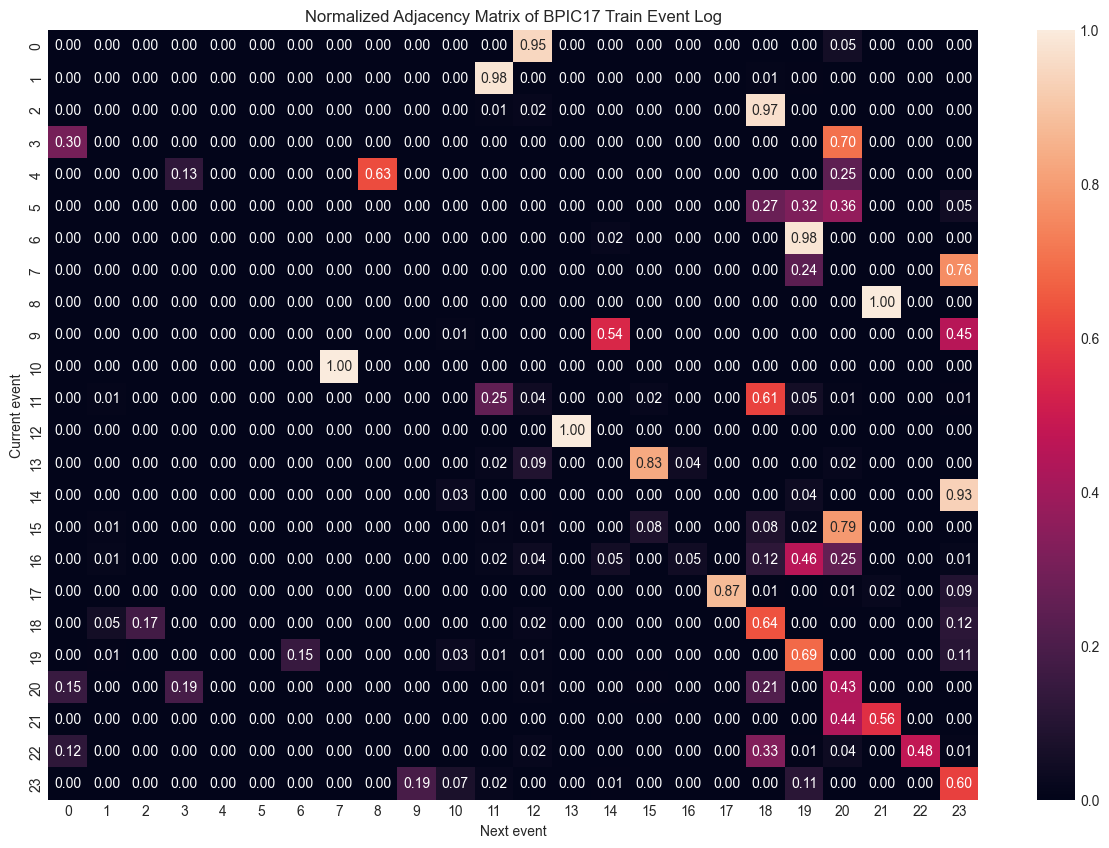

In [32]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(15, 10))
ax = sns.heatmap(normalized_adjacency[3:, 3:], annot=True, fmt=".2f", )
ax.set_title('Normalized Adjacency Matrix of BPIC17 Train Event Log')
ax.set_xlabel('Next event')
ax.set_ylabel('Current event')
plt.show()

Initilize custom cost  function based on transition matrix

In [33]:
transitions  = []
for i in range(len(trace_to_segment)  -  1):
    transitions.append((trace_to_segment[i], trace_to_segment[i+1]))
unique_transitions =  set(transitions)
len_unique_trans = len(unique_transitions)
print("Number of unique transitions: ", len_unique_trans)

Number of unique transitions:  15


In [34]:
optimizer = rpt.Pelt(custom_cost=TransitionCost(normalized_adjacency), jump=1, min_size=1)
optimizer.fit(trace_to_segment)

penalties = np.arange(0, 1, 0.01)
results = [optimizer._seg(penalty) for penalty in penalties]
cost_list  =  [sum(result.values()) for result in results]
seg_num_list = [len(result) for result in results]

In [35]:
best_aic = 1e10 
best_segments_num = 0
best_penalty  =  0

for i, (cost, segments_num) in enumerate(zip(cost_list, seg_num_list)):
    aic = 2 * segments_num - 2 * np.log(cost)
    if aic < best_aic:
        best_aic = aic
        best_segments_num = segments_num
        best_penalty  = penalties[i].round(3)

    
print("Best segments number by AIC: ", best_segments_num)
print("Best penalty by AIC: ", best_penalty)

Best segments number by AIC:  4
Best penalty by AIC:  0.99


In [36]:
optimizer = rpt.Pelt(custom_cost=TransitionCost(normalized_adjacency), jump=1, min_size=1)
breakpoints = optimizer.fit(trace_to_segment).predict(pen=best_penalty)

In [37]:
trace_segments  =  []
trace_seg_ids = []
for i, t in enumerate(trace_to_segment):
    if i  == 0 or i in breakpoints:
        trace_segments.append([t])
        trace_seg_ids.append([i])
    else:
        trace_segments[-1].append(t)
        trace_seg_ids[-1].append(i)

trace_seg_ids


[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9, 10], [11, 12], [13, 14, 15, 16, 17]]

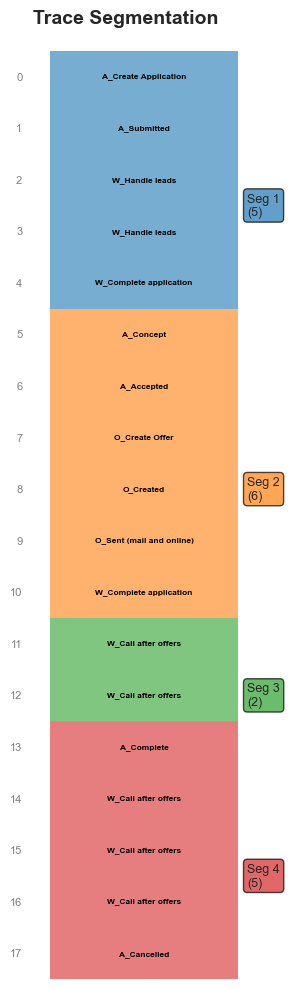

In [38]:
seg_boundaries = {}
palette = sns.color_palette(cc.glasbey_category10, n_colors=len(trace_segments))

for c, seg in enumerate(trace_seg_ids):
    seg_boundaries[(seg[0], seg[-1])] = palette[c]

visualize_trace_vertical(trace=case_to_segment.squeeze(0), 
                         activity_token_index=0, figsize=(3, 10),
                         seg_boundaries_colors=seg_boundaries, 
                         activity_lookup=test_log.itos['activity'])

### Best penalty detection based on Knee/elbow rule

In [ ]:
filtered_seg_nums = {}
for i, (sn, c) in enumerate(zip(seg_num_list, cost_list)):
    if sn not in filtered_seg_nums.keys():
        filtered_seg_nums[sn] = {"cost": c, "penalty": penalties[i].round(3)}

filtered_seg_nums

{8: {'cost': 6.62650144732774, 'penalty': 0.0},
 7: {'cost': 7.380737544727777, 'penalty': 0.1},
 6: {'cost': 8.064660765682067, 'penalty': 0.2},
 5: {'cost': 9.815318543934056, 'penalty': 0.5},
 4: {'cost': 10.28733721685974, 'penalty': 0.6}}

Knee at penalty: 0.5
Number of optimal segments (cost): 5 (9.81532)
Total trace cost: 12.86088


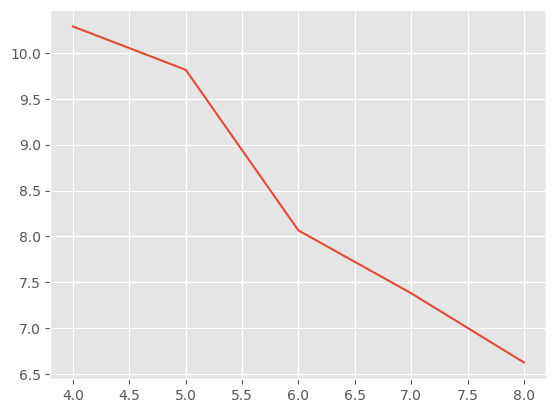

In [ ]:
plt.style.use('ggplot')

segments_number_list = list(filtered_seg_nums.keys())
costs_list = [res["cost"]  for res in filtered_seg_nums.values()]

knee_seg_num, knee_cost = KneeFinder(segments_number_list, costs_list).find_knee()
knee_penalty = filtered_seg_nums[knee_seg_num]['penalty']
print("Knee at penalty:", knee_penalty)
print("Number of optimal segments (cost):", int(knee_seg_num), f"({knee_cost :.5f})")

total_cost  = TransitionCost(normalized_adjacency).fit(trace_to_segment).error(0, len(trace_to_segment))
print("Total trace cost:", total_cost.round(5))

plt.plot(segments_number_list, costs_list)
plt.show()

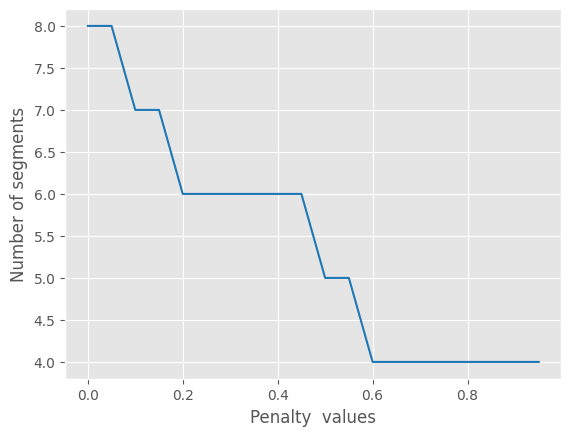

In [ ]:
plt.plot(penalties, seg_num_list,  color="tab:blue")
plt.xlabel("Penalty  values")
plt.ylabel("Number of segments")
plt.show()

# Calculate SHAP explanations

In [39]:
import shap
from typing import List
from shap import Explanation
from shap.utils._legacy import LogitLink, IdentityLink


from local_xai.seqshap.seqshap_kernel import SeqShapKernel
from local_xai.seqshap.plots import plot_segment_shap_heatmap
from timeshap.utils import calc_avg_event, calc_avg_sequence
from timeshap.wrappers.outcome_predictor_wrapper import OutcomePredictorWrapper 

plt.style.use('seaborn-v0_8-white') 

In [40]:
wrapped_model = OutcomePredictorWrapper(model, batch_budget=1, categorical_indices=[0], 
                                         target='next_activity', device=torch.device('cpu'))

fetching_f = lambda x, hs=None: wrapped_model(sequences=x, hidden_state=hs)

In [41]:
np.random.seed(RANDOM_SEED)
bc_data_ind = np.random.randint(0, 1000, size=100).tolist() 

bc_data = [ ]
for ind in bc_data_ind:
    bc_trace = train_dataset[ind]
    bc_trace_arr = np.concatenate([bc_trace[0].numpy(), bc_trace[1].numpy()], axis=-1)
    bc_trace_arr = np.expand_dims(bc_trace_arr, axis=0)
    bc_data.append(bc_trace_arr)
    
lengths = list(map(lambda x: x[0].shape[0], bc_data))
# Keep only short traces (length <= 30) for average event calculation
short_traces = [trace for trace in bc_data if trace.shape[1]<= 30]

max_length = max([trace.shape[1] for trace in short_traces])

bc_data_padded = [np.pad(trace, mode='constant', pad_width=((0, 0), (0, max_length-trace.shape[1]), (0, 0))) for trace in short_traces]
bc_padded_array = np.concatenate(bc_data_padded, axis=0)
print('Padded background data shape for the calculation of an average event: ', bc_padded_array.shape)

Padded background data shape for the calculation of an average event:  (45, 30, 11)


In [42]:
cat_features_ind: List[str|int] = [0]
num_features_ind: List[str|int] = [i+1 for i, _ in enumerate(train_log.features.numerical)]
all_feature_names = list(train_log.features.categorical) + list(train_log.features.numerical)

avg_sequence = calc_avg_sequence(data=bc_padded_array, 
                           categorical_feats=cat_features_ind, 
                           numerical_feats=num_features_ind,
                           model_features=all_feature_names)

avg_event = calc_avg_event(data=avg_sequence[np.where(avg_sequence[:, 0]!=0)],  # calculating average event only for rows with non-zero activities
                            categorical_feats=cat_features_ind, 
                            numerical_feats=num_features_ind,
                            model_features=all_feature_names)

In [43]:
explicand  =  case_to_segment
print("Model score for the explicand {:.5f}".format(fetching_f(explicand)[0].item()))
print("Model score on the avg event: {:.5f}".format(fetching_f(np.expand_dims(avg_event, axis=0))[0].item()))
fnull = fetching_f(np.tile(avg_event, (explicand.shape[1], 1))[np.newaxis, :])[0].item()
print("Model score on the baseline extended to the explicand shape: {:.5f}".format(fnull))

Model score for the explicand 0.00100
Model score on the avg event: 0.23552
Model score on the baseline extended to the explicand shape: 0.59073


In [44]:
accepted_case  = np.concatenate([test_dataset[0][0], test_dataset[0][1]], axis=1)

In [45]:
print("Model score for the accepted case {:.5f}".format(fetching_f(accepted_case)[0].item()))

Model score for the accepted case 0.94835


In [46]:
explainer = SeqShapKernel(fetching_f, avg_event, rs=52, mode="segment", 
                          segment_ids=trace_seg_ids, link=IdentityLink())
segment_level_sv = explainer.shap_values(explicand)

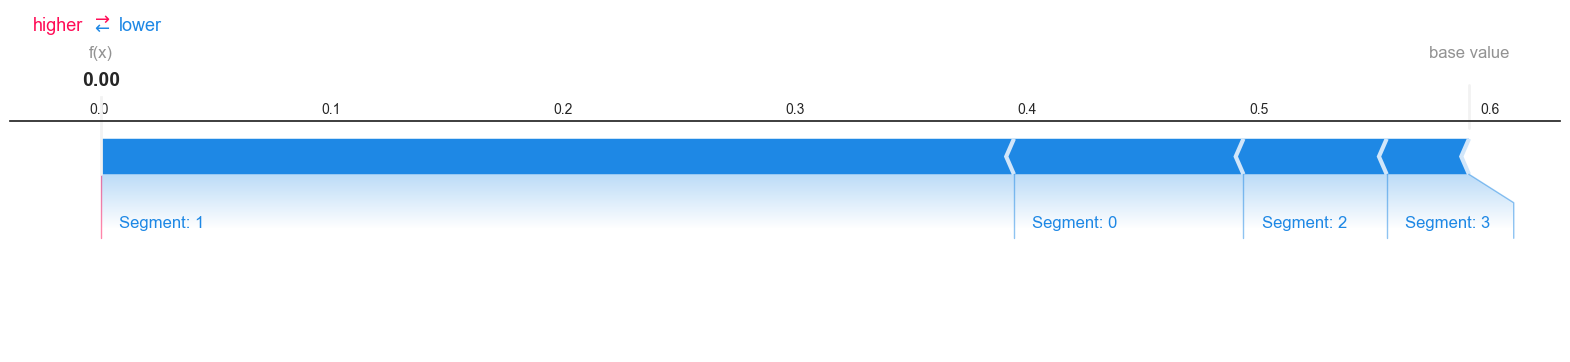

In [47]:
shap.initjs()

segment_names = getattr(explainer.data, "group_names")
segment_level_expl = Explanation(segment_level_sv, base_values=explainer.expected_value,
                          feature_names=segment_names)
shap.plots.force(segment_level_expl, matplotlib=True, contribution_threshold=0)

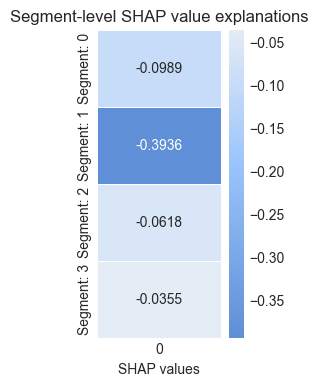

In [48]:
_ = plot_segment_shap_heatmap(segment_names, segment_level_sv)

## Estimating OOD samples in created coalitions

In [49]:
from utils.ae_model import LSTMAutoencoder
from utils.ae_trainer import LSTMAETrainer

In [53]:
ae_chkpts_path = r"D:\PycharmProjects\xAI-PPM\output\chekpoints\lstmae_bpi17.pth"

ae_model = LSTMAutoencoder(input_dim=11,
                           hidden_dim=64,
                           latent_dim=32,
                           num_layers=2,
                           dropout=0.2)

checkpoint = torch.load(ae_chkpts_path, map_location=torch.device('cpu'))
ae_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [54]:
ae_trainer = LSTMAETrainer(model=ae_model)
test_recon_loss, test_loss_list = ae_trainer.evaluate(test_loader)
print("Reconstruction loss on the test set: {:.3f} ± {:.3f}".format(test_recon_loss, np.std(test_loss_list)))

Reconstruction loss on the test set: 5.774 ± 1.085


Check the reconstruction error on the test log

In [55]:
ae_model.eval
explicand_tensor = torch.Tensor(explicand)
recon_explicand, latent_explicand = ae_model(explicand_tensor)

1) Marginal  distribution for missing segments imputation

In [ ]:
coalition_masks =  explainer.maskMatrix
segments_num = len(explainer.segment_ids)
coalitions_data  = explainer.synth_data
reconstructed_coalitions = {}
recon_loss  =  {}
criterion = torch.nn.MSELoss()

coalition_ind  = {}
num_seg_per_coal  = coalition_masks.sum(1) 
for i in range(1, segments_num):
    coalition_ind[i] = np.where(num_seg_per_coal== i)[0].tolist()
    coal_tensor = torch.Tensor(coalitions_data[coalition_ind[i]])
    reconstructed_coalitions[i], _ = ae_model(coal_tensor)

    recon_loss[i] = criterion(reconstructed_coalitions[i], coal_tensor).item()
    print(f"Number of coalitions with {i} original segment(s): ", len(coalition_ind[i]),"->", coalition_ind[i])


Number of coalitions with 1 original segment(s):  4 -> [0, 2, 4, 6]
Number of coalitions with 2 original segment(s):  6 -> [8, 9, 10, 11, 12, 13]
Number of coalitions with 3 original segment(s):  4 -> [1, 3, 5, 7]


In [ ]:
explainer.y, explainer.expected_value

array([[0.54540849],
       [0.284637  ],
       [0.21537216],
       [0.5434081 ],
       [0.59026939],
       [0.25378639],
       [0.58763093],
       [0.19839996],
       [0.19363955],
       [0.54748541],
       [0.54167253],
       [0.22054827],
       [0.27853891],
       [0.58646476]])

In [63]:
explainer.y - explainer.expected_value

array([[-0.0453195 ],
       [-0.30609098],
       [-0.37535582],
       [-0.04731989],
       [-0.0004586 ],
       [-0.3369416 ],
       [-0.00309706],
       [-0.39232802],
       [-0.39708844],
       [-0.04324257],
       [-0.04905546],
       [-0.37017971],
       [-0.31218907],
       [-0.00426322]])

In [64]:
segment_level_sv

array([-0.09894074, -0.39355501, -0.06175341, -0.03547446])